In [1]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,make_scorer
from sklearn import decomposition
from sklearn import preprocessing
from numpy.random import RandomState
from collections import Counter

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt


In [2]:
# define the input path and file
data_dir = '../data'
output_dir = '../outputs'
x_file = 'image-train.txt'
y_file = 'label-train.txt'
test_file = 'test-data.txt'
output1_file = 'y1.out'

n_row, n_col = 10, 10 
n_components = n_row * n_col

In [3]:
def load_data(data_dir,x_file,y_file):
    """
    Load the training data 
    Input: directory of data, filename of training image, filename of training label
    Output: dataset X in the shape of vector, dataset X in the shape of images, label
    """
    # load the data into data frame
    x = pd.read_csv(os.path.join(data_dir, x_file), sep=" ", header=None)
    y = pd.read_csv(os.path.join(data_dir, y_file), sep=" ", header=None)
    
    # length of data
    num_data = len(x)
    
    # transform the data into ndarray
    X = x.iloc[:, :].astype(int).values/255
    # define the size of one picture
    size = np.sqrt(X.shape[1]).astype(int)
    image_shape = (size,size)

    X_reshape = X.reshape((-1,size,size))

    Y = y.iloc[:, :].astype(int).values
    Y = Y.reshape((num_data,)).astype(np.float32)
    
    print("The shape of X is: %s" % str(X.shape))
    print("The shape of X_reshape is: %s" % str(X_reshape.shape))
    print("The shape of Y is: %s" % str(Y.shape))
    return X,X_reshape,Y

In [4]:
def get_count_by_counter(l):      
    """
    Check the distribution of the label
    Input: list of label
    Output: dictionary counting the distribution of the labels
    """
    count = Counter(l)   
    count_dict = dict(count)   
    
    return count_dict


In [5]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    """
    Data Visualization
    Input: title of images, dataset, ncol of printing, nrow of printing, colormap
    Output: Visualized images
    """
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    size = np.sqrt(images.shape[1]).astype(int)
    image_shape = (size,size)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)



In [6]:
def param_curve(result,param_name,filename):
    """
    Plot the learning curve between parameters vs accuracy
    Input: result from decision tree model, name of parameters(for x_axis), filename of the curve
    Output: Visualize the curve
    """
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV Evaluation",fontsize=16)

    param_data = result[('param_' + param_name)].data
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")

    ax = plt.gca()
    ax.set_xlim(param_data.min()-1, param_data.max()+1)
    ax.set_ylim(0.73, 1+0.05)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(param_data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g']):
        for sample, style in (('train', '-'), ('test', '--')):
            sample_score_mean = result['mean_%s_%s' % (sample, scorer)]
            sample_score_std = result['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

            best_index = np.nonzero(result['rank_test_%s' % scorer] == 1)[0][0]
            best_score = result['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.savefig(os.path.join(output_dir,filename))
    plt.grid('off')
    plt.show()
    

In [7]:
def output_pred(output_dir,filename,error,pred_vec):
    """
    Output the prediction
    Input: Directory of output, filename of output, training error, prediction of test set
    Output: file including classification error and predition of test set
    """
    output_path = os.path.join(output_dir, filename)
    with open(output_path,"w") as fd:
        fd.write('%f\n' % error)
        for pred in pred_vec:
            fd.write('%d\n' % pred.astype(np.int32))
    print("Finish output!")

In [8]:
X,X_reshape,Y = load_data(data_dir,x_file,y_file)
n_samples, n_features = X.shape
size = np.sqrt(X.shape[1]).astype(int)
image_shape = (size,size)

The shape of X is: (40000, 784)
The shape of X_reshape is: (40000, 28, 28)
The shape of Y is: (40000,)


In [9]:
label_count = get_count_by_counter(Y.tolist())
label_count

{1.0: 3986,
 5.0: 3882,
 6.0: 4135,
 2.0: 3971,
 4.0: 4013,
 0.0: 4100,
 9.0: 3922,
 7.0: 3925,
 3.0: 4068,
 8.0: 3998}

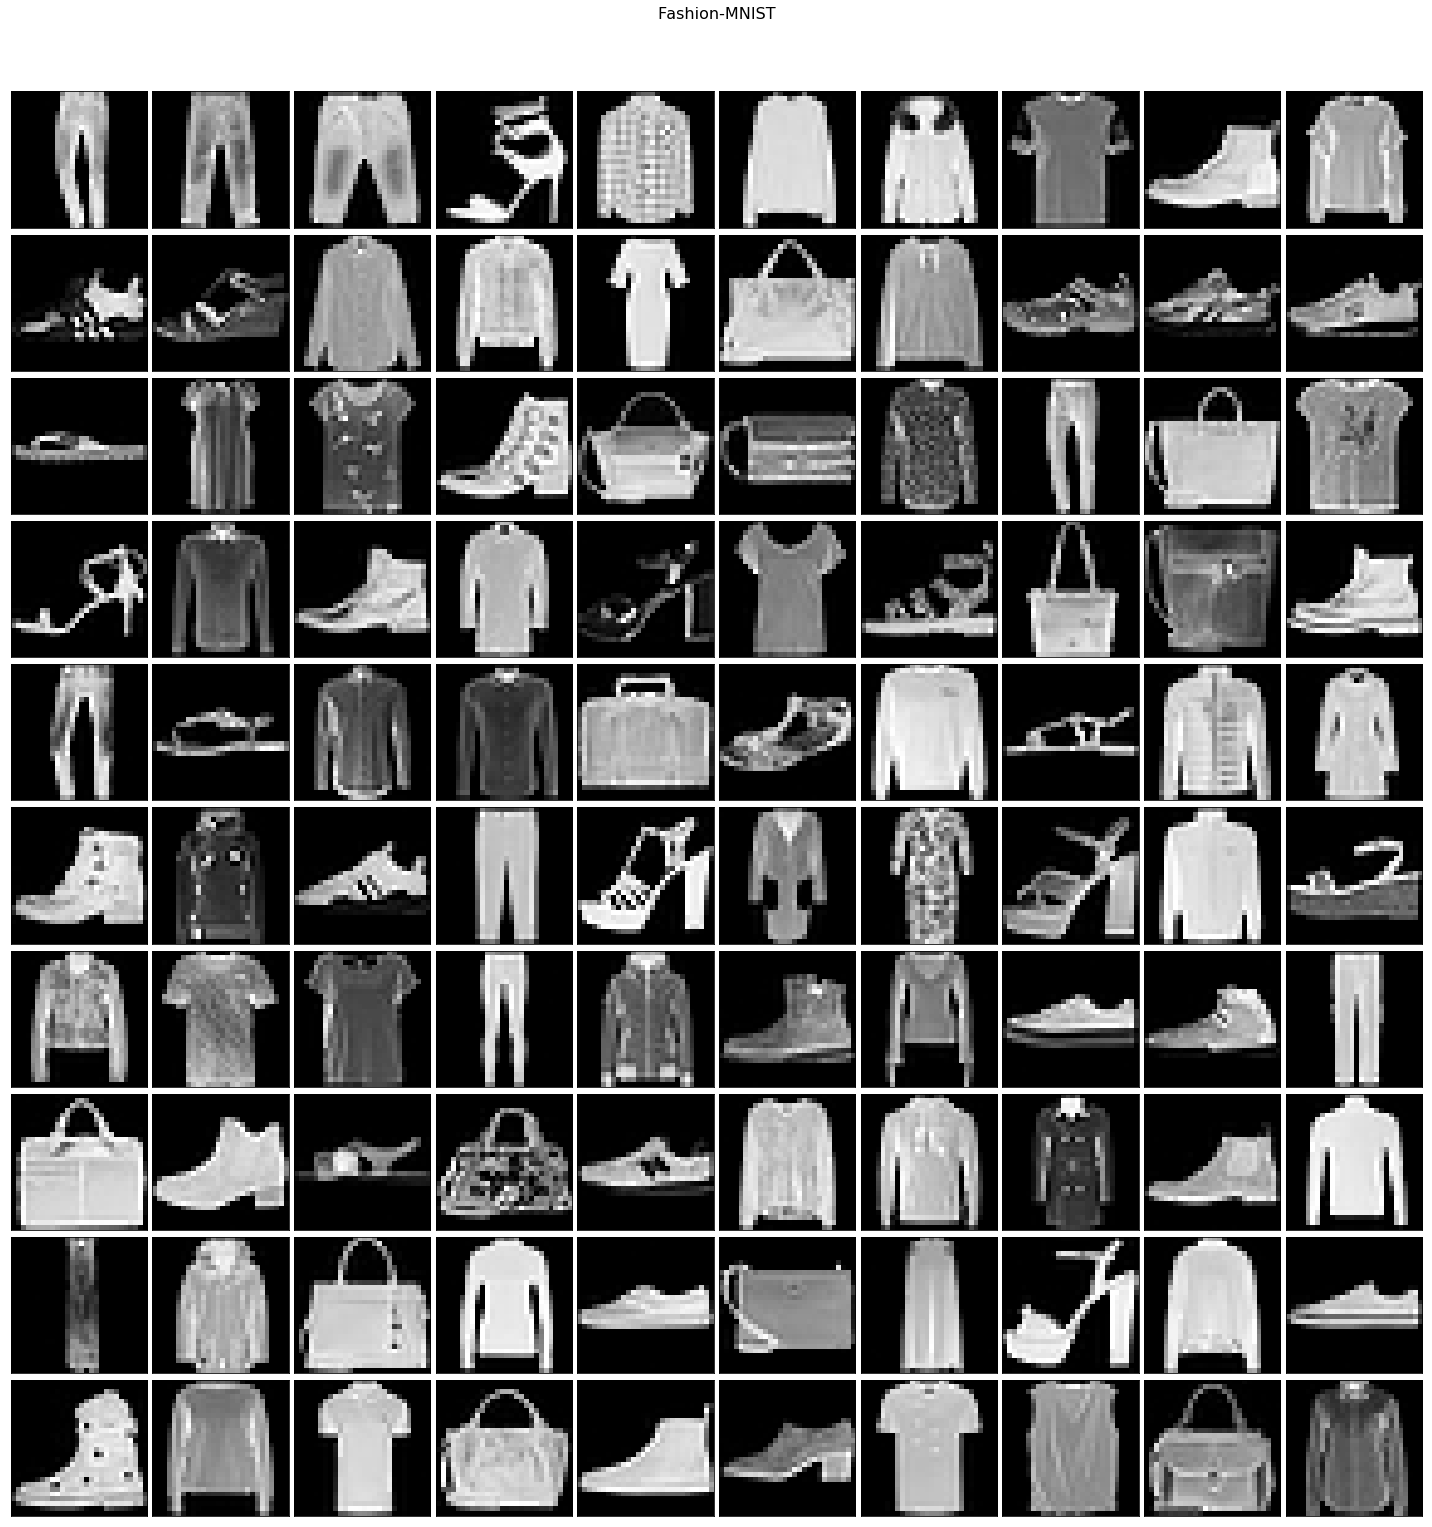

In [11]:
# #############################################################################
# Plot a sample of the input data
plot_gallery("Fashion-MNIST", X[:n_components])
plt.savefig(os.path.join(output_dir,'data_demo.png'))

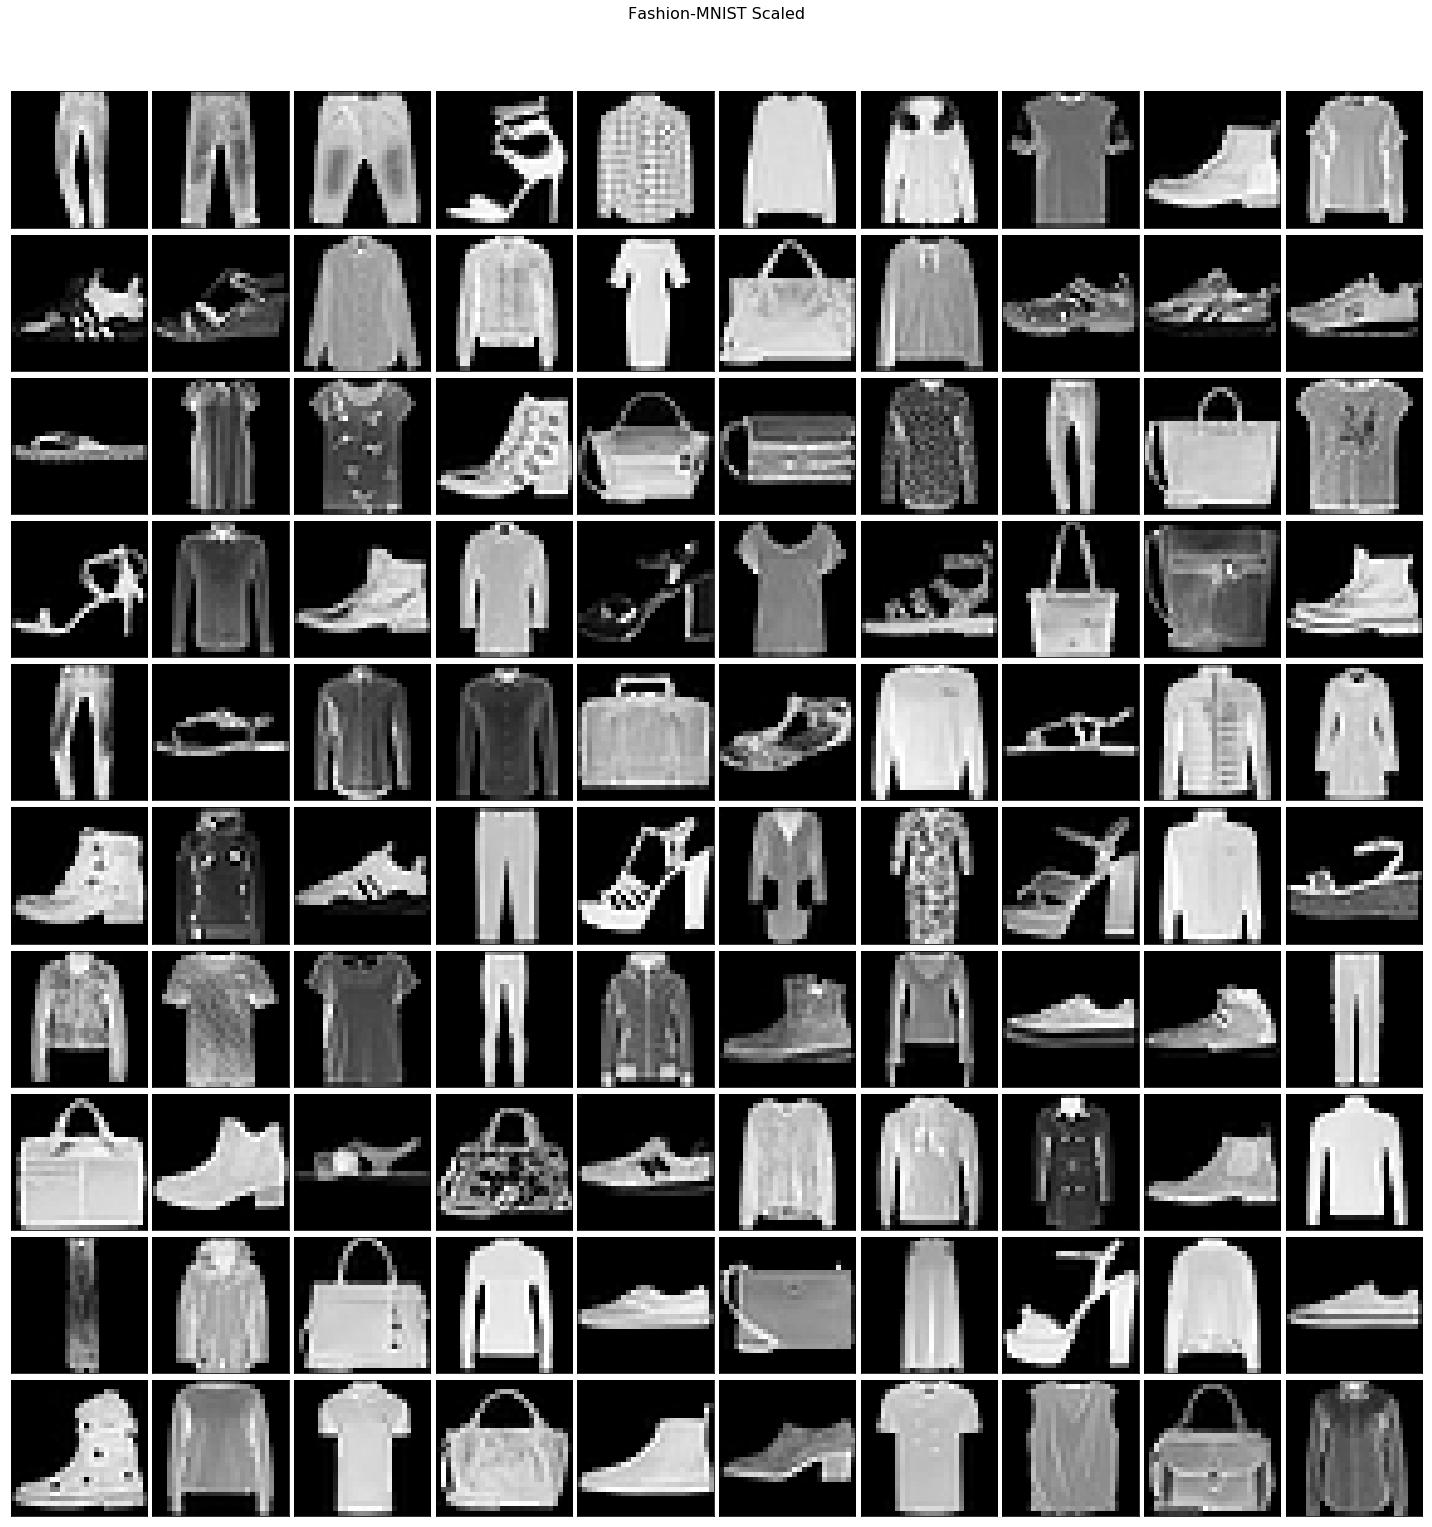

In [12]:
# scale the data
X_scaled = preprocessing.maxabs_scale(X)
X_scaled

# #############################################################################
# Plot a sample of the input data
plot_gallery("Fashion-MNIST Scaled", X_scaled[:n_components])

In [14]:
# dimension reduction from 784 to 10
pca_svd = decomposition.PCA(n_components=10, svd_solver='randomized',whiten=True)
X_transformed = pca_svd.fit_transform(X_scaled)
X_transformed.shape

(40000, 10)

In [15]:
# Grid Search CV   Params: min_samples_leaf, max_depth

scoring = {'Accuracy':make_scorer(accuracy_score)}
params = {'min_samples_leaf':range(1,6,1),'max_depth':range(10,100,10)}
gs = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                  param_grid=params,
                  scoring=scoring, cv=5, refit=False,return_train_score=True)
gs.fit(X_transformed,Y)
results = gs.cv_results_


In [16]:
results['mean_train_Accuracy']

array([0.77542513, 0.77333765, 0.77220642, 0.77040643, 0.76877518,
       0.96396248, 0.93862499, 0.92404997, 0.90971252, 0.89829998,
       0.99954377, 0.96258125, 0.94294999, 0.9239375 , 0.91004994,
       1.        , 0.96273123, 0.94303748, 0.92395001, 0.9100437 ,
       1.        , 0.96273123, 0.94303748, 0.92395001, 0.9100437 ,
       1.        , 0.96273123, 0.94303748, 0.92395001, 0.9100437 ,
       1.        , 0.96273123, 0.94303748, 0.92395001, 0.9100437 ,
       1.        , 0.96273123, 0.94303748, 0.92395001, 0.9100437 ,
       1.        , 0.96273123, 0.94303748, 0.92395001, 0.9100437 ])

In [17]:
results['mean_test_Accuracy']

array([0.742475, 0.741225, 0.739825, 0.740425, 0.73965 , 0.829325,
       0.817575, 0.81125 , 0.807375, 0.80355 , 0.84015 , 0.822075,
       0.816225, 0.811075, 0.8072  , 0.841   , 0.8225  , 0.81665 ,
       0.8106  , 0.807025, 0.841   , 0.8225  , 0.81665 , 0.8106  ,
       0.807025, 0.841   , 0.8225  , 0.81665 , 0.8106  , 0.807025,
       0.841   , 0.8225  , 0.81665 , 0.8106  , 0.807025, 0.841   ,
       0.8225  , 0.81665 , 0.8106  , 0.807025, 0.841   , 0.8225  ,
       0.81665 , 0.8106  , 0.807025])

In [18]:
# Pick the parameter with the highest mean accuracy in the validation(test) set

val_max_accuracy = results['mean_test_Accuracy'].max()
max_index = np.where(results['mean_test_Accuracy']== val_max_accuracy )[0]
max_index = np.array(max_index)
print(max_index)

[15 20 25 30 35 40]


In [19]:
# best combination  (40,1)
[results['params'][i] for i in max_index]

[{'max_depth': 40, 'min_samples_leaf': 1},
 {'max_depth': 50, 'min_samples_leaf': 1},
 {'max_depth': 60, 'min_samples_leaf': 1},
 {'max_depth': 70, 'min_samples_leaf': 1},
 {'max_depth': 80, 'min_samples_leaf': 1},
 {'max_depth': 90, 'min_samples_leaf': 1}]

In [20]:
# For the convenience of plotting and providing intuition, do the above procedure seperately
# Grid Search for max_depth
scoring = {'Accuracy':make_scorer(accuracy_score)}
params = {'max_depth':range(10,100,10)}
gs_depth = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                  param_grid=params,
                  scoring=scoring, cv=5, refit=False,return_train_score=True)
gs_depth.fit(X_transformed,Y)
results_depth = gs_depth.cv_results_

C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


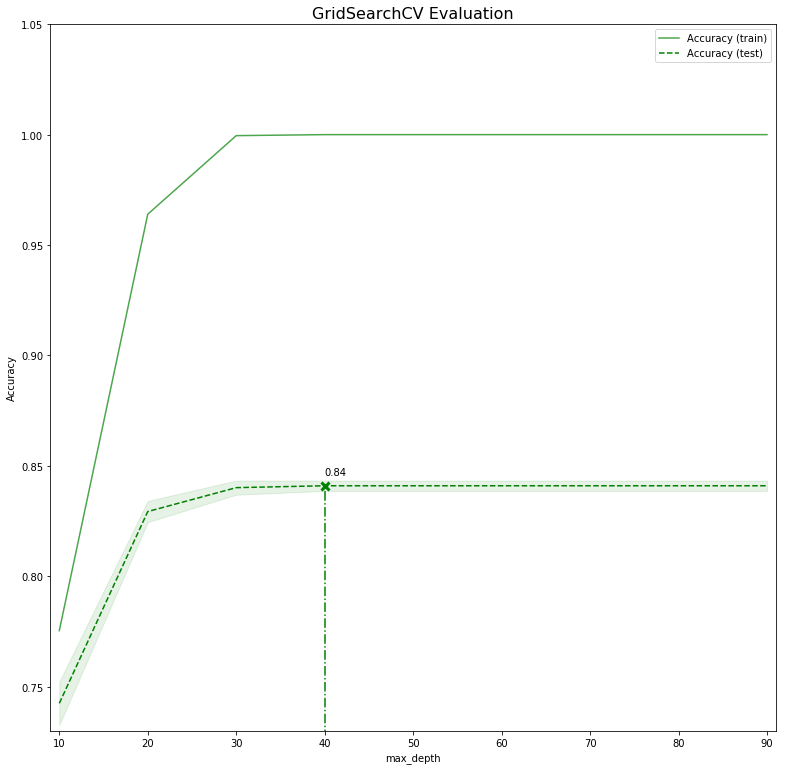

In [94]:
param_curve(results_depth,'max_depth','gridsearch_depth.png')


In [70]:
# For the convenience of plotting and providing intuition, do the above procedure seperately
# Grid Search for min_samples_leaf
scoring = {'Accuracy':make_scorer(accuracy_score)}
params = {'min_samples_leaf':range(1,6,1)}
gs_leaf = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                  param_grid=params,
                  scoring=scoring, cv=5, refit=False,return_train_score=True)
gs_leaf.fit(X_transformed,Y)
results_leaf = gs_leaf.cv_results_

C:\Users\VitoDH\Anaconda3\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


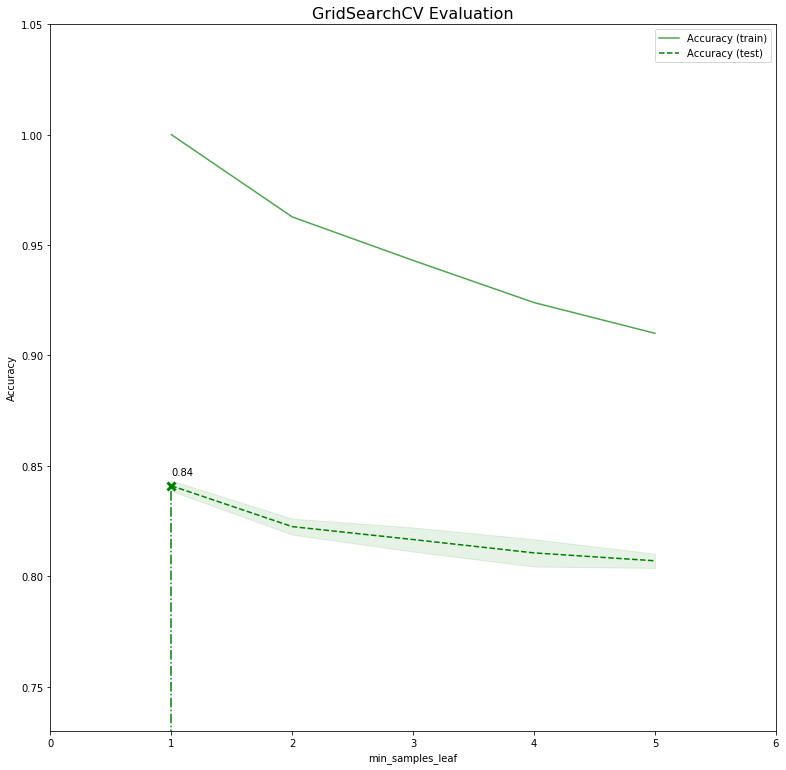

In [95]:
param_curve(results_leaf,'min_samples_leaf','gridsearch_leaf.png')


In [24]:
# Split the data set into training and validation
train_X,valid_X,train_Y,valid_Y = train_test_split(X_transformed,Y,test_size = 0.01, shuffle = True,random_state=42)
print("The size of training set is: %s " % str(train_X.shape))
print("The size of training label is: %s " % str(train_Y.shape))
print("The size of validation set is: %s " % str(valid_X.shape))
print("The size of validation label is: %s " % str(valid_Y.shape))

The size of training set is: (39600, 10) 
The size of training label is: (39600,) 
The size of validation set is: (400, 10) 
The size of validation label is: (400,) 


In [98]:
#training demo     
t1 = time.time()    
clf = tree.DecisionTreeClassifier(random_state=42,max_depth=40,min_samples_leaf=1)
clf = clf.fit(train_X,train_Y)
t2 = time.time() 
print("The training time is: %f s" % (t2-t1))

# training set accuracy
print("The training accuracy is: %f " % clf.score(train_X,train_Y))

# validation set accuracy
print("The validation accuracy is: %f " % clf.score(valid_X,valid_Y))

The training time is: 0.580256 s
The training accuracy is: 1.000000 
The validation accuracy is: 0.907500 


In [99]:
train_pred = clf.predict(train_X)
val_pred = clf.predict(valid_X)
# training set error
train_error = 1 - clf.score(train_X,train_Y)
print(train_error)
# validation set error
valid_error = 1 - clf.score(valid_X,valid_Y)
print(valid_error)

0.0
0.09250000000000003


In [40]:
# Load in test set and preprocessing
test = pd.read_csv(os.path.join(data_dir, test_file), sep=" ", header=None)
# transform the data into ndarray
test_X = test.iloc[:, :].astype(int).values/255
test_X_scaled = preprocessing.maxabs_scale(test_X)
test_X_transformed = pca_svd.fit_transform(test_X_scaled)

(5000, 10)

In [29]:
# Predictions on the test set
test_pred = clf.predict(test_X_transformed)
test_pred

array([4., 6., 5., ..., 9., 3., 3.], dtype=float32)

In [30]:
# Output the predictions and training error
output_pred(output_dir,output1_file,train_error,test_pred)

Finish output!


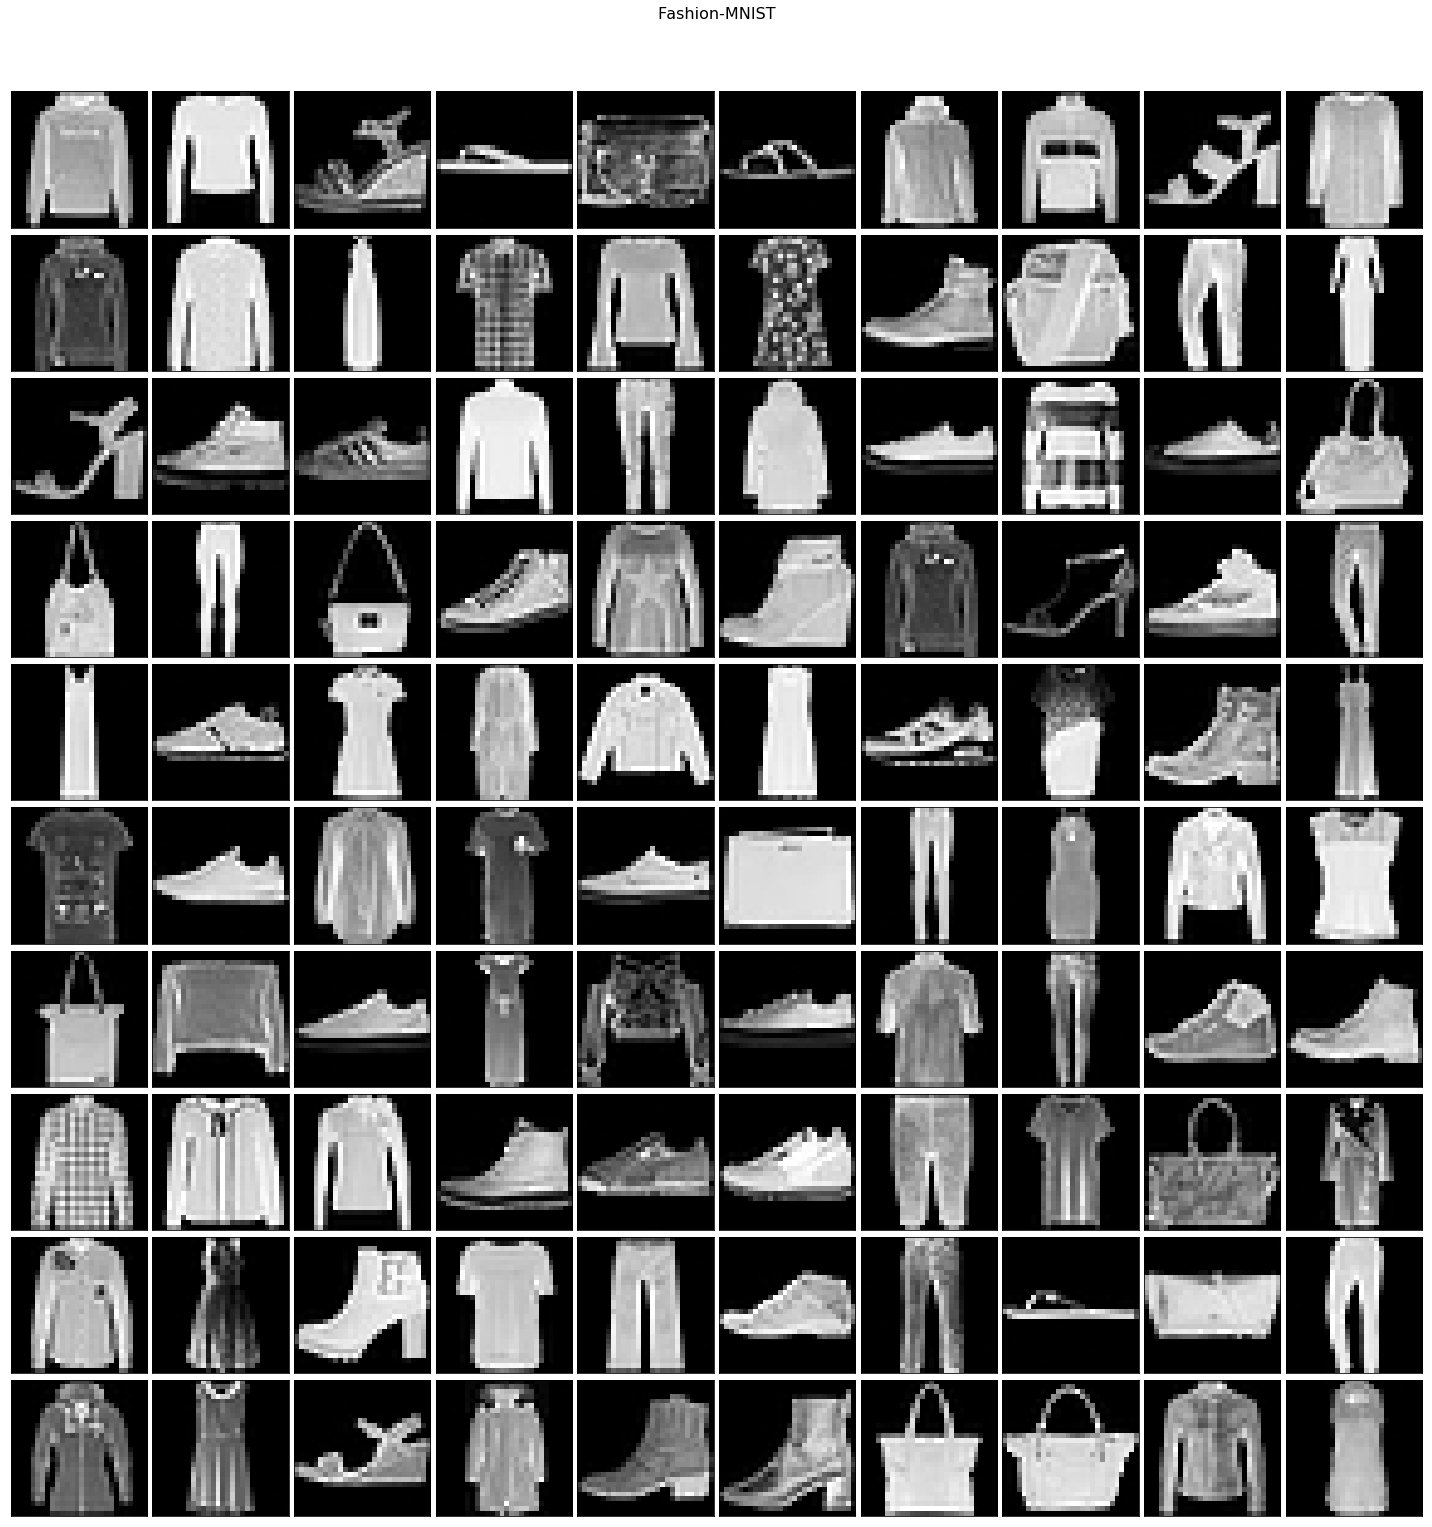

In [41]:
plot_gallery("Fashion-MNIST", test_X[:n_components])